In [1]:
import os 
os.chdir('../')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from models import LANGCAD 
from main import load_caption
import open_clip 

os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
default_setting = './configs/default/mvtecad.yaml'
model_setting = './configs/model/LANGCAD.yaml'
cfg = parser(True,default_setting, model_setting)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        )
device = 'cuda'

caption_dict = load_caption(
        datadir     = cfg.DATASET.datadir,
        dataset     = cfg.DATASET.dataset_name,
        class_names = cfg.DATASET.class_names
    )

loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        caption_dict  = caption_dict, 
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 8,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    

/usr/local/lib/python3.8/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)



 Experiment Name : 1223-only_contrastive-l2p



In [16]:
model.pool.load_pool('/Volume/VAD/LifeLongerAD/results/LANGCAD/MVTecAD/1223-only_contrastive-l2p/seed_0/last_pool.pth')

Load done


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = 'cuda'
model = model.to(device)
img_embed_dict = {} 
txt_embed_dict = {} 

prompts = model.create_prompts()
for cln, loaders in loader_dict.items():
    trainloader = accelerator.prepare(loaders['test'])

    txt_embeddings = [] 
    img_embeddings = [] 
    for imgs, _, _ in trainloader:
        
        features = model.embed_img(imgs).detach().cpu().numpy()
        query_features = np.mean(features,axis=(0,1))
        prompts = model.pool.retrieve_prompts(prompts, query_features).to(device)
        
        txt_embed = model.embed_text(pos).detach().cpu().numpy().mean(axis=1)
        img_embed = model.embed_img(imgs,prompts)@model.proj
        img_embed = img_embed.detach().cpu().numpy().mean(axis=1)
        txt_embeddings.append(txt_embed)        
        img_embeddings.append(img_embed)
        
    txt_embeddings = np.concatenate(txt_embeddings)
    txt_embed_dict[cln] = txt_embeddings 
    
    img_embeddings = np.concatenate(img_embeddings)
    img_embed_dict[cln] = img_embeddings 


txt_embeddings = np.concatenate(list(txt_embed_dict.values()))
img_embeddings = np.concatenate(list(img_embed_dict.values()))


# embeddings = np.concatenate([img_embeddings,txt_embeddings])
# tsne = TSNE()
# embeddings_2d = tsne.fit_transform(embeddings)

In [17]:
knowledge = np.vstack(model.pool.prompts)

In [18]:
tsne = TSNE() 
prompts_2d = tsne.fit_transform(knowledge)

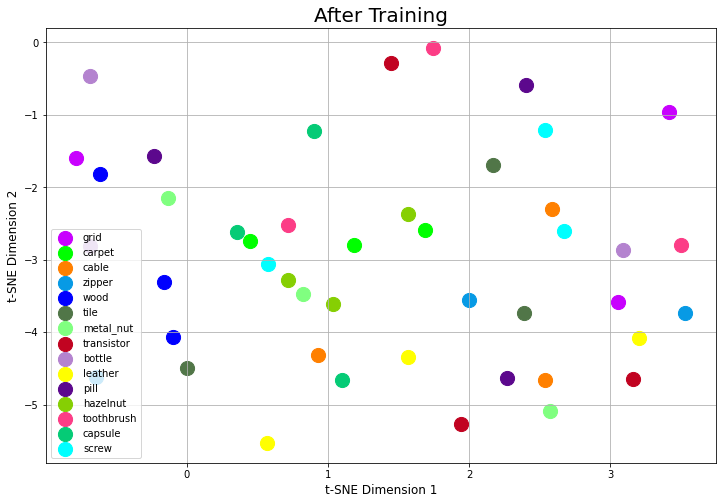

In [19]:
import matplotlib.pyplot as plt
from distinctipy import distinctipy

plt.figure(figsize=(12, 8))

# Distinctipy로 고유 색상 생성
num_classes = len(loader_dict.keys())
colors = distinctipy.get_colors(num_classes)

for i, cls in enumerate(list(loader_dict.keys())):
    embed = prompts_2d[i * 3:(i + 1) * 3, :]
    plt.scatter(embed[:, 0], embed[:, 1], s=200, color=colors[i], label=cls, marker='o')

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('After Training', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()


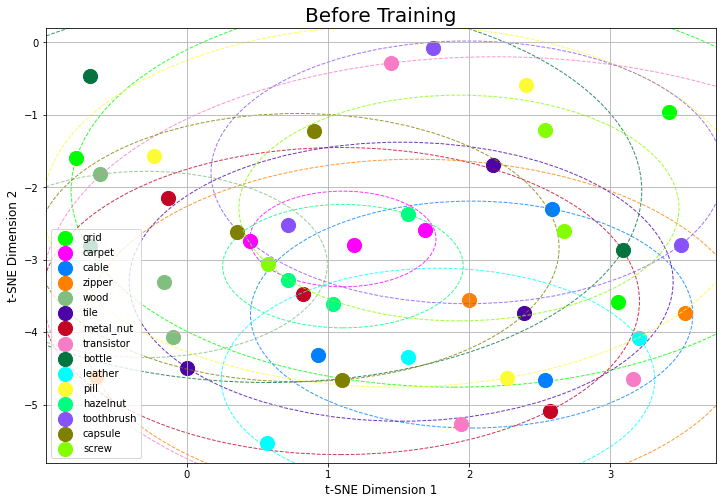

In [20]:
import matplotlib.pyplot as plt
from distinctipy import distinctipy
import numpy as np
from matplotlib.patches import Circle

plt.figure(figsize=(12, 8))

# Distinctipy로 고유 색상 생성
num_classes = len(loader_dict.keys())
colors = distinctipy.get_colors(num_classes)

# 최대 반지름 임계값 설정
MAX_RADIUS = 100  # 원하는 임계값으로 설정

for i, cls in enumerate(list(loader_dict.keys())):
    embed = prompts_2d[i * 3:(i + 1) * 3, :]
    # 각 클래스 점들에 대한 중심(centroid) 계산vvvv
    centroid = np.mean(embed, axis=0)
    # 각 점에서 중심까지의 거리 계산
    distances = np.linalg.norm(embed - centroid, axis=1)
    # 최대 거리로 원의 반지름 설정
    radius = np.max(distances)
    
    # 점 그리기
    plt.scatter(embed[:, 0], embed[:, 1], s=200, color=colors[i], label=cls, marker='o')
    
    # 반지름이 임계값보다 작을 경우에만 원 추가
    if radius <= MAX_RADIUS:
        circle = Circle(centroid, radius, color=colors[i], fill=False, linestyle='--', alpha=0.8)
        plt.gca().add_artist(circle)

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('Before Training', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()


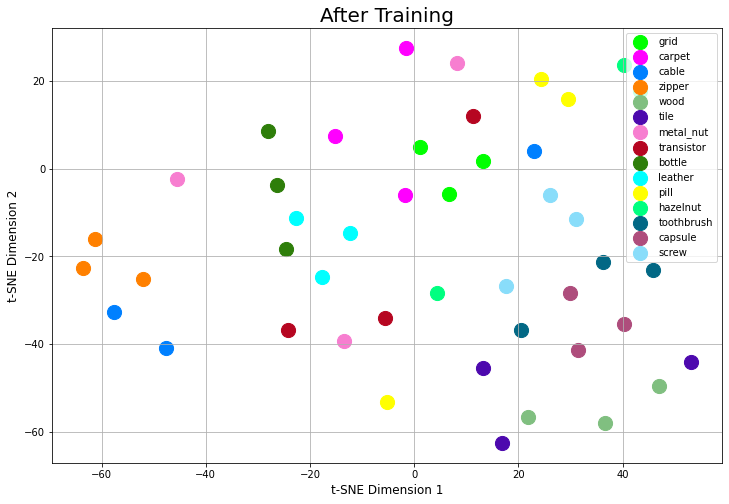

In [15]:
import matplotlib.pyplot as plt
from distinctipy import distinctipy

plt.figure(figsize=(12, 8))

# Distinctipy로 고유 색상 생성
num_classes = len(loader_dict.keys())
colors = distinctipy.get_colors(num_classes)

for i, cls in enumerate(list(loader_dict.keys())):
    embed = prompts_2d[i * 3:(i + 1) * 3, :]
    plt.scatter(embed[:, 0], embed[:, 1], s=200, color=colors[i], label=cls, marker='o')

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('After Training', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()


In [13]:
model.pool.prompts = []
for i in range(15):
    prompts = model.create_prompts()
    model.pool.prompts.append(torch.Tensor(prompts.prompts['3']))
prompts = torch.concat(model.pool.prompts).detach().cpu().numpy()    

In [17]:
cnt_cls = {}
colors = plt.cm.get_cmap('tab10', 15)  # Use 'tab10' colormap to provide distinct colors
for idx, (cln, loader) in enumerate(loader_dict.items()):
    dataloader = loader['train']
    length_data = len(dataloader.dataset)
    # num_embeddings = int(length_data * 196 * 0.103065)
    num_embeddings = int(length_data * 190 * 0.1 )    
    cnt_cls[cln] = num_embeddings
np.sum(list(cnt_cls.values()))    

68951

In [ ]:
len(model.pool.knowledge)

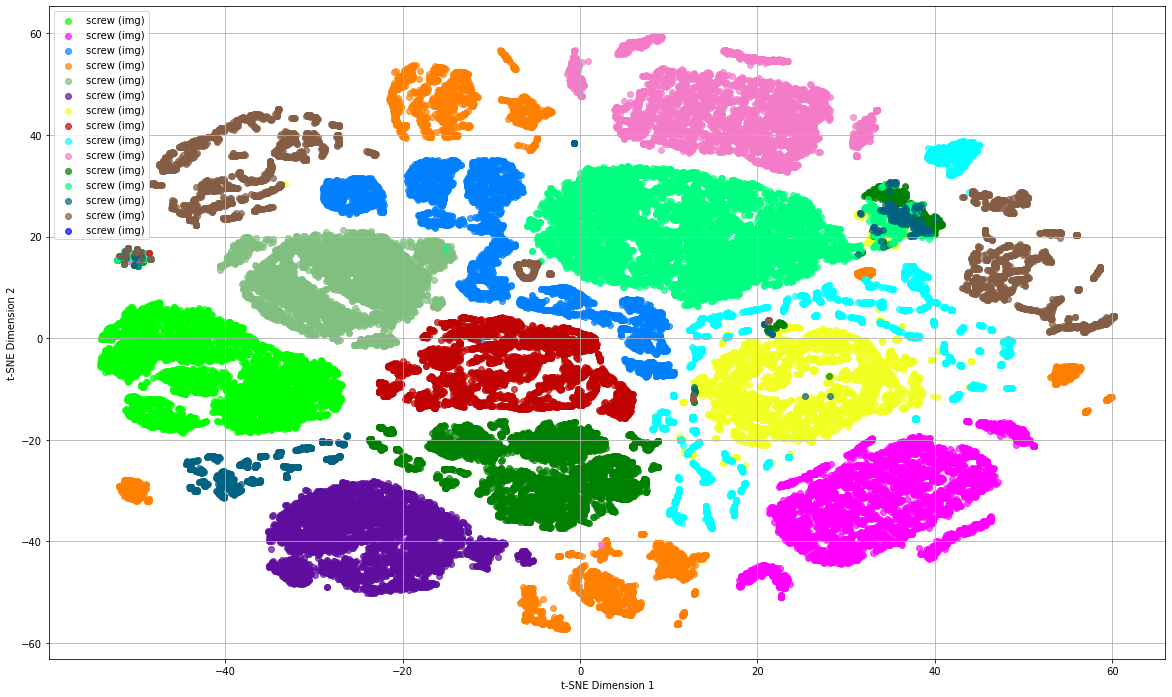

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from distinctipy import distinctipy
colors = distinctipy.get_colors(15)

# Define color map for consistent colors within the same class


plt.figure(figsize=(20, 12))
i = 0
for idx, (cls, cnt) in enumerate(cnt_cls.items()):
    
    color = colors[idx]
    f = i + cnt

    embed = prompts_2d[i:f]
    plt.scatter(embed[:, 0], embed[:, 1], alpha=0.7, color=color, label=f'{cln} (img)', marker='o')

    # txt = txtx.reshape(-1, 2)[i:f]
    # plt.scatter(txt[:, 0], txt[:, 1], alpha=0.7, color=color, label=f'{cln} (txt)', marker='^')

    i = f

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
cnt_cls = {}
colors = plt.cm.get_cmap('tab10', 15)  # Use 'tab10' colormap to provide distinct colors
for idx, (cln, embed) in enumerate(txt_embed_dict.items()):
    length_data = len(embed)
    num_embeddings = length_data
    cnt_cls[cln] = num_embeddings

In [7]:
i = 0 

var_cls_img={}
var_cls_txt={}
for cln, cnt in cnt_cls.items():
    f = i + cnt
    imgs = img_embeddings[i:f]
    txts = txt_embeddings[i:f]
    i=f
    
    var_cls_img[cln] = np.sum(np.var(imgs, axis=0,ddof=1))
    var_cls_txt[cln] = np.sum(np.var(txts, axis=0,ddof=1))
    
var_cls_img = pd.DataFrame(var_cls_img.items())
var_cls_txt = pd.DataFrame(var_cls_txt.items())

var_df = pd.merge(var_cls_img,var_cls_txt,on=0)
var_df.columns = ['Class','Image','Text']
var_df['Difference'] = var_df['Image'] - var_df['Text']

In [8]:
labels = []
for idx, (class_name, count) in enumerate(cnt_cls.items()):
    labels.extend([idx] * count)
labels = np.array(labels)

In [9]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt



# 응집도와 분리도 계산

results = []
for embeddings in [img_embeddings,txt_embeddings]:
    davies_bouldin = davies_bouldin_score(embeddings, labels)
    silhouette = silhouette_score(embeddings, labels)
    
    results.append([davies_bouldin,silhouette])
results = pd.DataFrame(results)    
results.columns = ['davies_boulding','silhouette']
results.index = ['Image','Text']

In [10]:
results['Var'] = var_df[['Image','Text']].mean(0)

In [11]:
results

,davies_boulding,silhouette,Var
Image,0.583095,0.686100,0.014606
Text,3.086263,0.007077,0.000486


In [118]:
if davies_bouldin > 10:
    print("Davies-Bouldin Index가 매우 높습니다. 이는 클래스 간의 경계가 불분명하고 응집도가 낮다는 것을 의미합니다.")
else:
    print("Davies-Bouldin Index가 낮습니다. 이는 클래스 간의 경계가 비교적 뚜렷하다는 것을 의미합니다.")

if silhouette < 0:
    print("Silhouette Score가 음수입니다. 이는 샘플들이 잘못된 클러스터에 속해 있거나 클래스 간의 구분이 명확하지 않다는 것을 나타냅니다.")
elif silhouette < 0.25:
    print("Silhouette Score가 낮습니다. 이는 클래스 간의 구분이 불명확하고 응집도가 낮음을 의미합니다.")
elif silhouette < 0.5:
    print("Silhouette Score가 중간 수준입니다. 이는 클래스 간의 구분이 어느 정도 있지만 여전히 개선의 여지가 있음을 의미합니다.")
else:
    print("Silhouette Score가 높습니다. 이는 클래스 간의 구분이 명확하고 응집도가 높음을 의미합니다.")

Davies-Bouldin Index가 낮습니다. 이는 클래스 간의 경계가 비교적 뚜렷하다는 것을 의미합니다.
Silhouette Score가 낮습니다. 이는 클래스 간의 구분이 불명확하고 응집도가 낮음을 의미합니다.
